In [2]:
import cv2
import numpy as np
import pandas as pd
import time
# from keras.preprocessing.image import ImageDataGenerator, load_img
import gc

DataNumber = 12500
ImageSize =256
import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
tf.test.gpu_device_name()

'/device:GPU:0'

#### Load VGG19 model

In [3]:
from keras.applications import VGG19
vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(ImageSize, ImageSize, 3))
for layer in vgg_conv.layers[:-5]:
    layer.trainable = False
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
vgg_conv.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### Create New Model

In [4]:
from keras import models
from keras import layers
from keras import optimizers
from keras.optimizers import Adam

model = models.Sequential()
model.add(vgg_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
__________

In [5]:
train_set=np.full((DataNumber*2, ImageSize, ImageSize, 3), 0, dtype = 'float16')
start = time.time()
for i in range(0,DataNumber):
    filename = 'train\cat\cat.'+str(i)+'.jpg'
    img = cv2.imread(filename,1)
    imgs = cv2.resize(img,(ImageSize, ImageSize)).reshape(ImageSize, ImageSize,3)
    train_set[i] = imgs
print("Read image of test set",(time.time()-start),'sec')

Read image of test set 39.98738670349121 sec


In [6]:
start = time.time()
for i in range(0,12500):
    filename = 'train\dog\dog.'+str(i)+'.jpg'
    img = cv2.imread(filename,1)
    imgs = cv2.resize(img,(ImageSize, ImageSize)).reshape(ImageSize, ImageSize,3)
    train_set[i+12500] = imgs
print("Read image of test set",(time.time()-start),'sec')

Read image of test set 42.09712862968445 sec


In [7]:
try:
    del train_cat, train_dog
except:
    print("released !")
gc.collect()
train_set /=255
train_label = np.append(np.zeros(DataNumber),np.ones(DataNumber),axis=0)

released !


In [8]:
batch_size = 20
epochs = 20
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4),  metrics=['accuracy'])
train_history = model.fit(train_set, train_label, batch_size=batch_size, epochs=epochs, validation_split=0.10, verbose=1, shuffle=True)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
 2320/22500 [==>...........................] - ETA: 18:06 - loss: 0.6188 - acc: 0.6841

KeyboardInterrupt: 

In [3]:
from keras.models import load_model
# creates a HDF5 file
#model.save('model_DogCat_VGG19_Base.h5') 
#load model
model=load_model ('model_DogCat_VGG19_Base_224.h5')

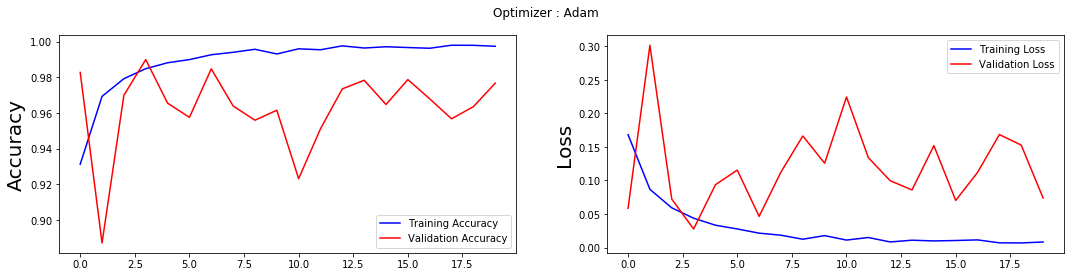

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,4))

plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=12)
plt.ylabel('Accuracy', fontsize=20)
plt.plot(train_history.history['acc'], color='b', label='Training Accuracy')
plt.plot(train_history.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)

plt.ylabel('Loss', fontsize=20)
plt.plot(train_history.history['loss'], color='b', label='Training Loss')
plt.plot(train_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [16]:
try:
    del train_set, train_label
except:
    print("released !")
gc.collect()

test_set=np.full((12500, ImageSize, ImageSize,3), 0, dtype = 'float16')
start = time.time()
for i in range(1,12500+1):
    filename = 'test\\'+str(i)+'.jpg'
    img = cv2.imread(filename,1)
    imgs = cv2.resize(img,(ImageSize, ImageSize)).reshape(ImageSize, ImageSize,3)
    test_set[i-1] = imgs
print("Read image of test set",(time.time()-start),'sec')
print('test set : ',test_set.shape)

released !
Read image of test set 63.02369022369385 sec
test set :  (12500, 256, 256, 3)


In [17]:
test_set = test_set/255
pro = model.predict(test_set,verbose=1)
pro = pro.ravel()
sub = pd.DataFrame({'id':[i for i in range(1,12501)],'label':pro})
sub.to_csv('submission.csv',index=False)

12500/12500 [==============================] - 258s 21ms/step
